In [134]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

In [135]:
#import os
#def GetDesktopPath():
#    return os.path.join(os.path.expanduser("~"), 'Desktop')
#path = GetDesktopPath()

SQL

In [136]:
cklist_confirm_query = """ 
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      ,[status]
      ,[rejectReason]
      /*,[kickOffMeetingDate]*/
      ,[baseOverDueDate] as 'actualCloseMeetingDate'
      ,[submitDate] as 'actualGMLASubmitDate'
      /*,[IsByPass]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_CONFIRM]

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/

  WHERE [IsByPass] = '0'
"""

project_schedule_query = """ 
SELECT [ProjectSizeId] as 'projectSizeId'
      /*
      ,[PROJECT_NAME]
      ,[T_GT_ProjectSchedule].[TASK_ID]
      */
      ,[DESC_OF_TASK]
      /*
      ,[T_GT_TaskBaseInfo].[Note]
      ,[IsPM]
      */
      ,DATEADD(DAY,-21,[Current_Date]) as 'estCloseMeetingDate'
      /* Design review -21 days */
  FROM [PR_WEB2].[dbo].[T_GT_ProjectSchedule]

  LEFT JOIN [PR_WEB2].[dbo].[T_GT_TaskBaseInfo] 
  ON [T_GT_ProjectSchedule].[TASK_ID] = [T_GT_TaskBaseInfo].TASK_ID

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ProjectSizeId = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID
  
  WHERE DESC_OF_TASK
  IN ('Mechanical Design Review','Factory Prototype Design Review','Pilot Run Design Review')
"""

cklist_issue_query = """
SELECT [T_GMLA_CKLIST_ISSUE].[projectSizeId]
      /*,[PROJECT_CATEGORY] as 'Segment'*/
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      /*,[T_GMLA_CKLIST_ISSUE].[categoryId]*/
      ,[riskType] as 'Risk'
      /*,[categoryName] as 'Category'*/
      /*,[T_GMLA_CKLIST_ISSUE].[id]*/
      /*,[no] as 'No'*/
      /*,[T_GMLA_CKLIST_ISSUE].[status]*/
      /*,[T_GMLA_CKLIST_ISSUE].[updated_at]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_ISSUE]
  
  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names */
  
  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/
  
  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_CATEGORY]
  ON [T_GMLA_CKLIST_ISSUE].categoryId=[T_GMLA_BS_CATEGORY].id
  /* Join 6 category name via id */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_CKLIST]
  ON ([T_GMLA_CKLIST_ISSUE].[categoryId] = [T_GMLA_CKLIST].[categoryId]
  AND [T_GMLA_CKLIST_ISSUE].id = [T_GMLA_CKLIST].id
  AND [T_GMLA_CKLIST_ISSUE].projectSizeId = [T_GMLA_CKLIST].projectSizeId
  AND [T_GMLA_CKLIST_ISSUE].typeId = [T_GMLA_CKLIST].typeId)
  /* Join serval datas */
"""

In [137]:
server = 'T1-PE-SUPPORT' 
database = 'PR_WEB2' 
username = 'pieng' 
password = 'Q2iT5cwHJW3FH'
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
cklist_confirm = pd.read_sql(cklist_confirm_query, cnxn)
project_schedule = pd.read_sql(project_schedule_query, cnxn, parse_dates='estCloseMeetingDate')
cklist_issue = pd.read_sql(cklist_issue_query, cnxn)

Hanlde cklist_issue for project risk info.

In [138]:
# Risk 4 = blue 1 star = Risk 2, replace blue star
cklist_issue.Risk.replace(to_replace= 4,value = 2, inplace=True)

In [139]:
cklist_issue = cklist_issue.sort_values('Risk', ascending=False).drop_duplicates(subset=['projectSizeId','Project_Name','Phase'], keep='first').sort_values('projectSizeId')

Handle cKlist_confirm

In [140]:
cklist_confirm.replace('0001-01-08 00:00:00.0000000 +08:00', np.nan, inplace=True)

In [141]:
cklist_confirm.actualCloseMeetingDate = pd.to_datetime(cklist_confirm.actualCloseMeetingDate, utc=True).dt.tz_convert('Asia/Taipei').dt.date
cklist_confirm.actualGMLASubmitDate = pd.to_datetime(cklist_confirm.actualGMLASubmitDate,utc=True).dt.tz_convert('Asia/Taipei').dt.date

In [142]:
cklist_confirm.head()

,projectSizeId,Project_Name,Phase,status,rejectReason,actualCloseMeetingDate,actualGMLASubmitDate
0,766,GAD 13,GMLA1,0,None,NaT,NaT
1,766,GAD 13,GMLA2,0,None,NaT,NaT
2,766,GAD 13,GMLA3,0,None,NaT,NaT
3,775,zumo X,GMLA1,0,None,NaT,NaT
4,775,zumo X,GMLA2,0,None,NaT,NaT


Merge project_schedule

In [143]:
project_schedule.estCloseMeetingDate = project_schedule.estCloseMeetingDate.dt.tz_convert('Asia/Taipei').dt.date

In [144]:
project_schedule['Phase'] = project_schedule.DESC_OF_TASK.map(
    {'Mechanical Design Review':'GMLA1','Factory Prototype Design Review':'GMLA2','Pilot Run Design Review':'GMLA3'})
project_schedule.drop_duplicates(subset=['projectSizeId','Phase'], inplace=True)
# Some project have multi-design review date in PMsystem

In [145]:
overall = pd.merge(left=cklist_confirm, right=project_schedule, how='left', on=['projectSizeId','Phase'])
overall.drop('DESC_OF_TASK', axis=1, inplace=True)

In [146]:
def mergeCloseMeeting(actualCloseMeetingDate, estCloseMeetingDate):
    if actualCloseMeetingDate is pd.NaT:
        return estCloseMeetingDate
    else:
        return actualCloseMeetingDate
overall['mergedCloseMeetingDate'] = np.vectorize(mergeCloseMeeting)(overall.actualCloseMeetingDate, overall.estCloseMeetingDate)

In [147]:
overall['targetGMLASubmitDate'] = (overall.mergedCloseMeetingDate + BDay(8)).dt.date

In [148]:
def on_time(actualDate, targetDate):
    if actualDate is pd.NaT or targetDate is pd.NaT:
        return None
    elif actualDate > targetDate:
        return 0
    else:
        return 1
overall['on_time'] = np.vectorize(on_time)(overall.actualGMLASubmitDate, overall.targetGMLASubmitDate)

In [149]:
overall = pd.merge(left=overall, right=cklist_issue, on=['projectSizeId','Project_Name','Phase'], how='left')

On time

Handle delay_but_rejected projects

In [150]:
def delay_but_rejected(on_time, rejectReason):
    if on_time is None:
        return None
    elif on_time == False and rejectReason != None:
        return 1
    else:
        return 0
overall['delay_but_rejected'] = np.vectorize(delay_but_rejected)(overall['on_time'], overall['rejectReason'])

Manage column order

In [151]:
overall_show = overall[['projectSizeId','Project_Name','Phase','Risk','status','actualCloseMeetingDate','estCloseMeetingDate','mergedCloseMeetingDate','actualGMLASubmitDate','targetGMLASubmitDate','on_time','delay_but_rejected']].set_index('projectSizeId')

In [152]:
overall_show.to_excel('overall_show.xlsx')

Delayed projects

In [153]:
delayed_projects = overall[(overall.on_time == False)].sort_values('targetGMLASubmitDate')

In [154]:
actual_delayed_projects = overall[(overall.on_time == False) & (overall.delay_but_rejected == False)].sort_values('targetGMLASubmitDate')

Resample

In [155]:
overall_resampled = overall.copy()

In [156]:
overall_resampled = overall_resampled[overall_resampled.status == 1]

In [157]:
overall_resampled.targetGMLASubmitDate = pd.to_datetime(overall_resampled.targetGMLASubmitDate)

In [158]:
overall_resampled = overall_resampled.set_index('targetGMLASubmitDate').resample(rule='BM').agg({'Project_Name':'count','on_time':'sum','delay_but_rejected':'sum'})

In [159]:
overall_resampled.rename(columns={'Project_Name':'total_projects','on_time':'on_time_projects','rejectReason':'rejcted_projects'}, inplace=True)

Convert datetime format

In [161]:
overall_resampled['on_time_rate'] = (100* (overall_resampled.on_time_projects / overall_resampled.total_projects)).round(2)

In [162]:
overall_resampled['actual_on_time_rate'] = (100* ((overall_resampled.on_time_projects+ overall_resampled.delay_but_rejected) / overall_resampled.total_projects)).round(2)

In [164]:
overall_resampled

,total_projects,on_time_projects,delay_but_rejected,on_time_rate,actual_on_time_rate
targetGMLASubmitDate,,,,,
2020-12-31,8,3,2,37.50,62.50
2021-01-29,9,7,1,77.78,88.89
2021-02-26,9,5,3,55.56,88.89
2021-03-31,11,10,1,90.91,100.00
2021-04-30,13,11,1,84.62,92.31
2021-05-31,11,10,1,90.91,100.00
2021-06-30,12,12,0,100.00,100.00
2021-07-30,8,6,2,75.00,100.00
2021-08-31,2,2,0,100.00,100.00


In [165]:
#on_time_resampled.to_excel(path+'\on_time.xlsx')

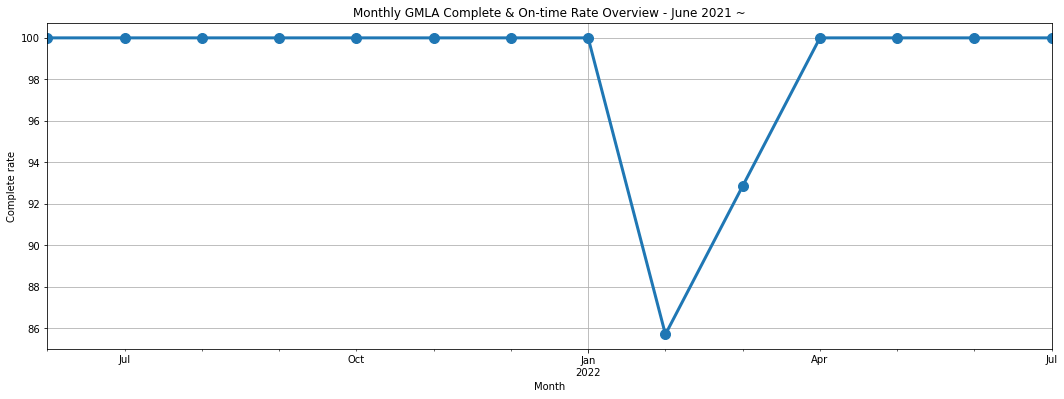

In [175]:
ax = overall_resampled['2021-06':].actual_on_time_rate.plot(figsize=(18,6), marker='o', markersize=10 ,lw=3, grid=True)
ax.set_xlabel('Month');
ax.set_ylabel('Complete rate');
ax.set_title('Monthly GMLA Complete & On-time Rate Overview - June 2021 ~');
plt.savefig('on_time',bbox_inches = "tight")